**Lab 8 Image Search - Bag of Visual Words**

The concept of “Bag of Visual Words” is taken from the related “Bag of Word” concept of Natural Language Processing.
In the bag of word model, the text is represented with the frequency of its word without taking into account the order of the words (hence the name ‘bag’).

The main idea behind the counting of the word is:

Documents that share a large number of the same keywords, regardless of the order the keywords appear in, are considered to be relevant to each other.

Bag of Visual Words
In Computer Vision, the same concept is used in the bag of visual words. Here instead of taking the word from the text,  image patches and their feature vectors are extracted from the image into a bag. Features vector is nothing but a unique pattern that we can find in an image.

To put it simply, Bag of Visual Word is nothing but representing an image as a collection of unordered image patches, as shown in the below illustration.



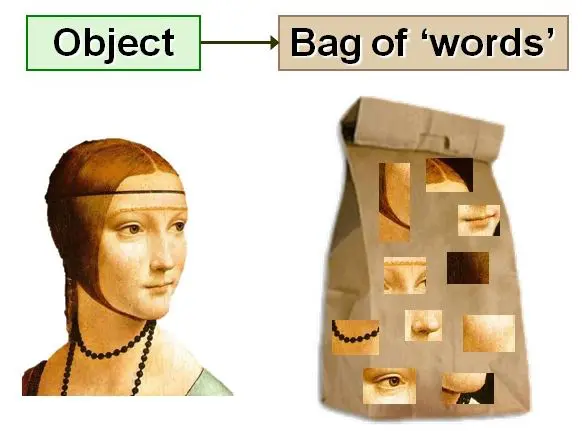

**What is the Feature?**

Basically, the feature of the image consists of keypoints and descriptors. Keypoints are the unique points in an image, and even if the image is rotated, shrink, or expand, its keypoints will always be the same. And descriptor is nothing but the description of the keypoint. The main task of a keypoint descriptor is to describe an interesting patch(keypoint)in an image.

In [ ]:
import cv2
import numpy as np
import os
import matplotlib.pyplot as plt
import random
import pylab as pl
from sklearn.metrics import confusion_matrix,accuracy_score

**Image classification with Bag of Visual Words**

This Image classification with Bag of Visual Words technique has three steps:

Feature Extraction – Determination of Image features of a given label.

Codebook Construction – Construction of visual vocabulary by clustering, followed by frequency analysis.

Classification – Classification of images based on vocabulary generated using SVM.

Let implement each step...

Let's first download the dataset. Write the code to download it from https://github.com/gvogiatzis/CS3320/raw/main/data/Lab8.zip and unzip it in Images folder

Write the code to get the subfolders in the Lab8 dataset, and print the names.

The dataset has two folder - cat and dog. The images related to cat and dog are in their respected folders. Let's print the sub-folder names to confirm the same. 

Let's read all the files path and store them in image_paths for future use, after reading printing the total number of images read from the given directory.

In [ ]:
def img_list(path):
    return (os.path.join(path,f) for f in os.listdir(path))

In [ ]:
image_paths=[]
image_classes=[]

for name in class_names:
    dir_=os.path.join(path,name)
    class_path=img_list(dir_)
    image_paths+=class_path  

len(image_paths)

Let's append the class with each image, we know each folder contains relevant images, therefore, if the path has Cat folder, the images inside are related to cat and vice versa. The following code perform the above task:

In [ ]:
D = []
for i in range(len(image_paths)):
  if "Cat" in image_paths[i]:
    D.append((image_paths[i], 'Cat'))
  else:
    D.append((image_paths[i], 'Dog'))

print(len(D))

41


Let's randomly shuffle the dataset and split it into training and test dataset.

In [ ]:
dataset = D
random.shuffle(dataset)
train = dataset[:37]
test = dataset[37:]

image_paths, y_train = zip(*train)
image_paths_test, y_test = zip(*test)

Feature Extraction

The first step to build a bag of visual words is to perform feature extraction by extracting descriptors from each image in our dataset.

Feature representation methods deal with how to represent the patches as numerical vectors. These vectors are called feature descriptors.

A good descriptor should have the ability to handle the intensity, rotation, scale and affine variations to some extent.

We will be using ORB in this lab.

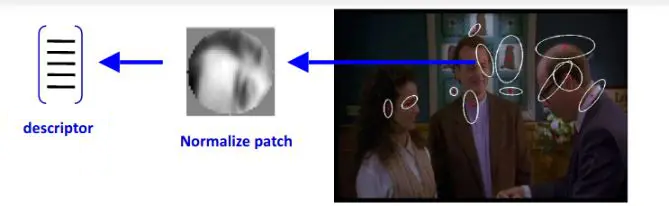

Let's try ORB on a single image to visualize the keypoints extracted by this apporach.

In [ ]:
orb=cv2.ORB_create()
im=cv2.imread(image_paths[0])
plt.imshow(im)

In [ ]:
def draw_keypoints(vis, keypoints, color = (0, 255, 255)):
    for kp in keypoints:
            x, y = kp.pt
            plt.imshow(cv2.circle(vis, (int(x), int(y)), 2, color))

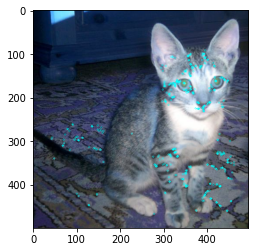

In [ ]:
kp = orb.detect(im,None)
kp, des = orb.compute(im, kp)
img=draw_keypoints(im,kp)

Now, let's calculate the key points for all the training images. 

In [ ]:
des_list=[]
for image_pat in image_paths:
    im=cv2.imread(image_pat)
    kp=orb.detect(im,None)
    print(image_pat)
    keypoints,descriptor= orb.compute(im, kp)
    des_list.append((image_pat,descriptor))

descriptors=des_list[0][1]
for image_path,descriptor in des_list[1:]:
    descriptors=np.vstack((descriptors,descriptor))

descriptors.shape

descriptors_float=descriptors.astype(float)

Codewords and Codebook Construction

The vectors generated in the feature extraction step above are now converted into the codewords which is similar to words in text documents. Codewords are nothing but vector representation of similar patches. This codeword also produces a codebook is similar to a word dictionary

This step normally accomplished via the k-means clustering algorithm.

In [ ]:
from scipy.cluster.vq import kmeans,vq
k=200
voc,variance=kmeans(descriptors_float,k,1)
im_features=np.zeros((len(image_paths),k),"float32")
for i in range(len(image_paths)):
    words,distance=vq(des_list[i][1],voc)
    for w in words:
        im_features[i][w]+=1

Classification

The next step consists of representing each image into a histogram of codewords.

It is done by first applying the keypoint detector or feature extractor and descriptor to every training image, and then matching every keypoint with those in the codebook.

The result of this is a histogram where the bins correspond to the codewords, and the count of every bin corresponds to the number of times the corresponding codeword matches a keypoint in the given image. In this way, an image can be represented by a histogram of codewords.

The histograms of the training images can then be used to learn a classification model. Here we are using SVM as a classification model.

In [ ]:
from sklearn.preprocessing import StandardScaler
stdslr=StandardScaler().fit(im_features)
im_features=stdslr.transform(im_features)

In [ ]:
from sklearn.svm import LinearSVC
clf=LinearSVC(max_iter=80000)
clf.fit(im_features,np.array(y_train))

LinearSVC(max_iter=80000)

In [ ]:
LinearSVC(C=1.0, class_weight=None, dual=True, fit_intercept=True,
          intercept_scaling=1, loss='squared_hinge', max_iter=80000,
          multi_class='ovr', penalty='l2', random_state=None, tol=0.0001,
          verbose=0)

LinearSVC(max_iter=80000)

Your task is to read the test images (similar to train images), extract their key points, and store all of them in test_feature.

Once, you have the test features, write the code to tranform (similar to train). 

Let's use the classifier to predict the classes for test set and compare the result with actual class.

In [ ]:
predict_classes=[]
for r in clf.predict(test_features):
  predict_classes.append(r)

true_classes=[]
for i in y_test:
  true_classes.append(i)

print(predict_classes)

print(true_classes)

Let's print the accuray of the classifer.

In [ ]:
accuracy=accuracy_score(true_classes,predict_classes)
print(accuracy*100)